In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

## **Data Preprocessing**

In [2]:
df = pd.read_csv('/kaggle/input/booksdata/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9945 entries, 0 to 9944
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           9945 non-null   object 
 1   Ease_Score      9945 non-null   float64
 2   Download_Count  9945 non-null   int64  
 3   Index           9945 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 310.9+ KB


In [3]:
df[['Ease_Score','Download_Count']].describe()

,Ease_Score,Download_Count
count,9945.000000,9945.000000
mean,70.758904,192.865661
std,12.006392,1344.537166
min,0.700000,21.000000
25%,62.500000,64.000000
50%,71.800000,86.000000
75%,80.400000,134.000000
max,99.700000,80680.000000


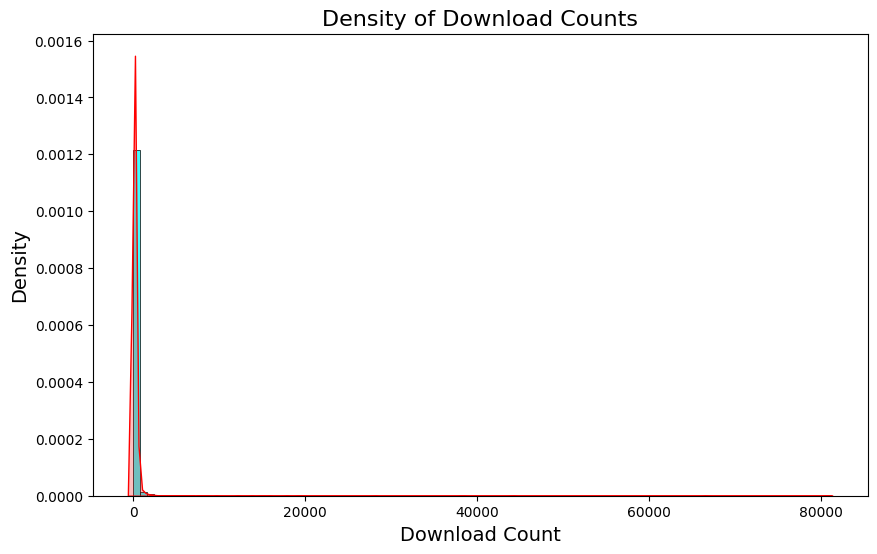

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Download_Count'], 
             color='cyan', 
             edgecolor='black', 
             stat='density',
             bins=100)
sns.kdeplot(df['Download_Count'], 
            color='red', 
            linewidth=1,
           fill=True) 
plt.title('Density of Download Counts', fontsize=16)
plt.xlabel('Download Count', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

Từ kết quả trực quan trên ta thấy biểu đồ lệch phải nặng, nên ta xét đến việc xử lý các giá trị ngoại lai, thực hiện biến đổi dữ liệu.

In [5]:
df['Download_Count'] = np.log10(df['Download_Count'])

In [6]:
df['Download_Count'] = np.where (df['Download_Count'] >= df['Download_Count'].quantile(0.95),df['Download_Count'].quantile(0.95),df['Download_Count'])

In [7]:
scaler = StandardScaler()
df['Download_Count'] = scaler.fit_transform(df['Download_Count'].values.reshape(-1,1))

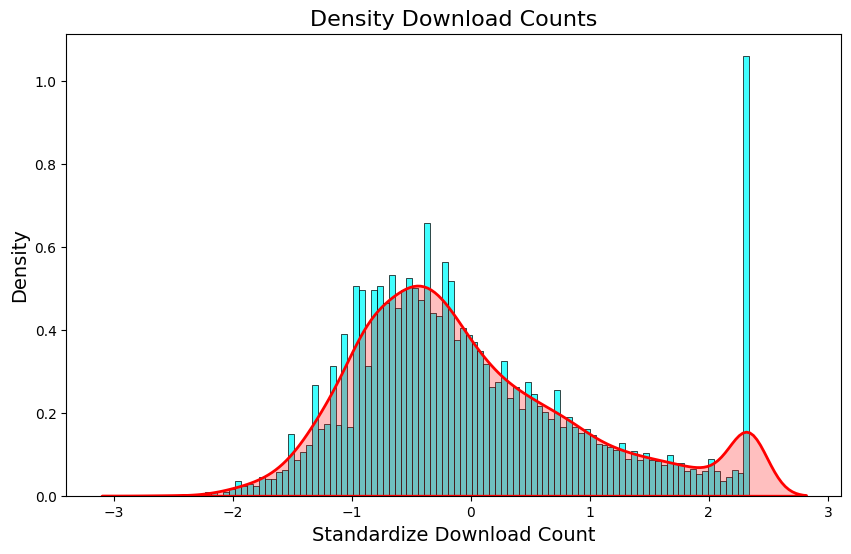

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Download_Count'], 
             color='cyan', 
             edgecolor='black', 
             stat='density',
             bins=100)
sns.kdeplot(df['Download_Count'], 
            color='red', 
            linewidth=2,
           fill=True) 
plt.title('Density Download Counts', fontsize=16)
plt.xlabel('Standardize Download Count', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

## **Natural Language Preprocessing**

Như đã thấy, tập dữ liệu chứa các dữ liệu dạng chuỗi chưa được chuẩn hóa. Để xây dựng dữ liệu correlation matrix giữa các đối tượng, việc xử lý các chuỗi này là nhu cầu cần thiết.  

Thực hiện các bước dữ liệu:
- Word Tokenization: thực hiện tách các dữ liệu dạng chuỗi thành từng đối tượng dạng chuỗi thành một tập các từ.
- Stop words Removal: thực hiện loại bỏ các từ thông dụng.
- Stemming: thực hiện chuẩn hóa các từ loại về dạng cơ bản của từ đó.

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

### Word Tokenization

In [10]:
df['Processed_Title'] = df['Title'].apply(word_tokenize)

### Stopwords Removal

In [11]:
df['Processed_Title'] = df['Processed_Title'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

### Stemming

In [12]:
df['Processed_Title'] = df['Processed_Title'].apply(lambda tokens: [stemmer.stem(word)for word in tokens])

In [13]:
df['Processed_Title'] = df['Processed_Title'].apply(lambda tokens: ' '.join(tokens))

### Term Frequency-Inverse Document Frequency

Sử dụng **TfidfVectorizer** để chuyển đổi văn bản thành biểu diễn số dưới dạng ma trận **TF-IDF** (Term Frequency-Inverse Document Frequency) với:
- **TF** (Term Frequency): Đo lường tần suất của một từ xuất hiện trong một tài liệu so với tổng số từ trong tài liệu đó.  
- **IDF** (Inverse Document Frequency): Đo lường mức độ phổ biến của một từ trên toàn bộ tập dữ liệu. Từ càng xuất hiện ở nhiều tài liệu thì trọng số của nó càng thấp.


In [14]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['Processed_Title'])
sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [15]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
df['Popularity'] = kmeans.fit_predict(df[['Download_Count']])

## Recommendation system based on user needs.

Hệ thống đề xuất được xây dựng theo phương pháp Content-Based Filtering để đưa ra gợi ý những cuốn sách có nội dung tương tự. Ngoài ra hệ thống được bổ sung tính năng như lọc theo độ nổi tiếng và sắp xuất tăng hoặc giảm tùy thôi mức độ dễ dọc của từng cuốn sách.

In [16]:
def get_index(title,df=df):
    """
    Lấy ra vị trí của sách trong bộ dữ liệu.
    
    Args:
        title (str): Title của cuốn sách.
        df (pd.DataFrame): DataFrame chứa thông tin cụ thể của từng sách.
    
    Returns:
        pd.Index: Vị trí của cuốn sách trong bộ dữ liệu.
    """
    return df.index[df['Title'] == title][0]

In [17]:
def get_similar_books(book_title,sim_matrix=sim_matrix,df=df):
    """
    Lấy ra những cuốn sách có độ tương đồng với cuốn sách hiện tại.
    
    Args:
        book_title (str): Title của cuốn sách.
        sim_matrix (np.ndarray): Ma trận thể hiện độ tương quan của 1 đối tượng sách với tất cả đối tượng sách khác.
        df (pd.DataFrame): DataFrame chứa thông tin cụ thể của từng sách.
    
    Returns:
        pd.DataFrame: Danh sách sách có tương quan với sách được yêu cầu.
    """
    index = get_index(book_title)
    sim_books = pd.concat([pd.DataFrame(sim_matrix[index],columns=['Similarity']),df[['Ease_Score','Popularity']]],axis = 1) 
    return sim_books[sim_books['Similarity'] != 0]

In [18]:
def recommend_books(title,df=df,sim_matrix=sim_matrix,popularity_filter=None, sort_by_ease_score=None, top_n=10):
    """
    Hệ thống gợi ý sách với các bộ lọc và sắp xếp. Hệ thống lấy ra top_n cuốn sách có độ tương đồng cao 
    nhất. Người dùng có thêm lựa chọn lọc theo độ nổi tiếng hoặc có thể chọn sắp xếp tăng giảm theo độ
    dễ đọc tùy nhu cầu.
    
    Args:
        title (str): Title của cuốn sách.
        df (pd.DataFrame): DataFrame chứa thông tin cụ thể của từng sách.
        popularity_filter (int, optional): Lọc theo độ nổi tiếng (1: nổi tiếng, 0: chưa nổi tiếng, None: không lọc).
        sort_by_ease_score (str, optional): Sắp xếp theo Ease_Score ('asc' tăng dần, 'desc' giảm dần, None: không sắp xếp).
        top_n (int, optional): Số lượng sách cần gợi ý (mặc định là 10).
    
    Returns:
        pd.DataFrame: Danh sách sách được gợi ý theo thứ tự ưu tiên.
    """
    sim_data = get_similar_books(title)
    sim_data = sim_data.sort_values(by='Similarity',ascending=False)[1:top_n+1]
    
    if popularity_filter is not None:
        sim_data = sim_data[sim_data['Popularity'] == popularity_filter]

    if sort_by_ease_score == 'asc':
        sim_data = sim_data.sort_values(by='Ease_Score', ascending=True)
    elif sort_by_ease_score == 'desc':
        sim_data = sim_data.sort_values(by='Ease_Score', ascending=False)
        
    indices = sim_data.index
        
    return df['Title'].iloc[indices]

In [19]:
title_01 = "The Master Spirit"	
print(recommend_books(title_01))
print("\n")
print(recommend_books(title_01,sort_by_ease_score='asc'))
print("\n")
print(recommend_books(title_01,popularity_filter=1,sort_by_ease_score='asc',))

9234                        The World Masters
1097                  The Spirit of Christmas
5826                              Master Race
2638                         Masters of Space
6171                      The Japanese Spirit
6973               The Ministry of the Spirit
4013                          Master Sunshine
3166                      The Master's Violin
1472                     Masters of the Guild
8641    The Spirit of Place, and Other Essays
Name: Title, dtype: object


6171                      The Japanese Spirit
8641    The Spirit of Place, and Other Essays
6973               The Ministry of the Spirit
1097                  The Spirit of Christmas
9234                        The World Masters
4013                          Master Sunshine
2638                         Masters of Space
1472                     Masters of the Guild
3166                      The Master's Violin
5826                              Master Race
Name: Title, dtype: object


6171                  

In [20]:
title_02 = "The Believing Years"	
print(recommend_books(title_02))
print("\n")
print(recommend_books(title_02,sort_by_ease_score='asc'))
print("\n")
print(recommend_books(title_02,popularity_filter=1,sort_by_ease_score='desc'))

63                        The Cruise of the Make-Believes
6825    The Will to Believe, and Other Essays in Popul...
4720                                 A Year in the Fields
9353                                     Three Years' War
8502                                 A Mother's Year Book
5965    History of the war in the Peninsula and in the...
6698    Twenty-Two Years a Slave, and Forty Years a Fr...
5444    Behind the Scenes; or, Thirty years a slave, a...
6822                                   The Locusts' Years
1002                                     In the year 2889
Name: Title, dtype: object


5965    History of the war in the Peninsula and in the...
6825    The Will to Believe, and Other Essays in Popul...
6698    Twenty-Two Years a Slave, and Forty Years a Fr...
9353                                     Three Years' War
6822                                   The Locusts' Years
8502                                 A Mother's Year Book
4720                                 A Year

In [21]:
title_03 = "Dumps - A Plain Girl"	
print(recommend_books(title_03))
print("\n")
print(recommend_books(title_03,sort_by_ease_score='desc'))
print("\n")
print(recommend_books(title_03,popularity_filter=0,sort_by_ease_score='asc',))

9805                                        Plain English
2846                                 When They Were Girls
8903                                          Penny Plain
3717                             Plain Tales of the North
5951                                 Judith of the Plains
6481                           The Plain Man and His Wife
5594                                   A Bookful of Girls
4605                  The Girl Warriors: A Book for Girls
5298    The Geologic Story of the Great Plains\r\nA no...
4907                                 A Girl of the People
Name: Title, dtype: object


4907                                 A Girl of the People
8903                                          Penny Plain
3717                             Plain Tales of the North
5594                                   A Bookful of Girls
5951                                 Judith of the Plains
4605                  The Girl Warriors: A Book for Girls
9805                                       

In [22]:
ease_score_sort = None
popularity = None
top_n = 10

In [23]:
title = input("Enter title: ")

Enter title:  Phoebe, Junior


In [24]:
ease_score_sort = input("Sort: ")

Sort:  asc


In [25]:
popularity = int(input("Popularity: "))

Popularity:  0


In [26]:
top_n = int(input("Top: "))

Top:  5


In [27]:
print(recommend_books(title,sort_by_ease_score=ease_score_sort,popularity_filter=popularity,top_n=top_n))

8567                          Quest on Phoebe
4598                             Jerry Junior
6452    Phoebe Daring: A Story for Young Folk
5458                        The Junior Trophy
Name: Title, dtype: object
